In [1]:
import datetime
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ranking

In [2]:
def parse_row(tr, category):
    td = tr.find_all("td")[:6]
    return dict(
        timestamp=datetime.datetime.utcnow().isoformat(),
        category=category,
        rank=int(td[0].b.getText()),
        name=td[2].b.getText().strip(),
        job=td[3].img.get("src").split("/")[-1].split(".")[0],
        specialization=td[3].a.get("href").split("/")[-1],
        mastery=td[3].a.getText().lower().strip(),
        level=int(td[5].b.getText())
    )

def parse_page(resp):
    category = resp.url.split("/")[-1].split("?")[0]
    soup = BeautifulSoup(resp.text)
    ranking_table = soup.find(id="rankingTable")
    rows = ranking_table.find_all("tr")
    data = [parse_row(r, category) for r in rows[1:]]
    return data

def parse_total(resp):
    soup = BeautifulSoup(resp.text)
    ranking_table = soup.find(id="rankingTable")
    return int(ranking_table.p.b.getText())

def get_ranking(page):
    url = f"https://maplelegends.com/ranking/all?page={page}"
    return requests.get(url)

In [6]:
first = get_ranking(1)
total = parse_total(first)
pages = total // 5
total, pages

(192718, 38543)

In [54]:
indices = sorted(set(np.append(np.geomspace(2, pages, 100), np.linspace(1, pages, 110)).astype(int)))
len(indices)

200

(array([78., 18., 15., 14., 14., 12., 13., 12., 12., 12.]),
 array([1.00000e+00, 3.85520e+03, 7.70940e+03, 1.15636e+04, 1.54178e+04,
        1.92720e+04, 2.31262e+04, 2.69804e+04, 3.08346e+04, 3.46888e+04,
        3.85430e+04]),
 <BarContainer object of 10 artists>)

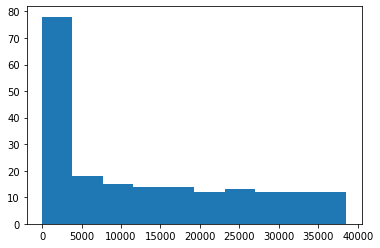

In [55]:
plt.hist(indices)

In [56]:
res = []
for i in tqdm(indices):
    resp = get_ranking(i)
    res.append(parse_page(resp))

  0%|          | 0/200 [00:00<?, ?it/s]

In [58]:
df = pd.DataFrame(sum(res, []))
df

,timestamp,category,rank,name,job,specialization,mastery,level
0,2021-05-09T07:29:05.999614,all,1,Unlucky,magician,cleric,bishop,200
1,2021-05-09T07:29:05.999614,all,2,Babo,thief,assassin,night lord,200
2,2021-05-09T07:29:05.999614,all,3,Nude,thief,assassin,night lord,200
3,2021-05-09T07:29:05.999614,all,4,JayChou,magician,cleric,bishop,200
4,2021-05-09T07:29:05.999614,all,5,Zeretius,bowman,hunter,bowmaster,200
...,...,...,...,...,...,...,...,...
995,2021-05-09T07:42:07.050445,all,192711,Lawkes,beginner,all,beginner,2
996,2021-05-09T07:42:07.050445,all,192712,Troyy,beginner,all,beginner,2
997,2021-05-09T07:42:07.050445,all,192713,Liridas,beginner,all,beginner,2
998,2021-05-09T07:42:07.050445,all,192714,Footwear,beginner,all,beginner,2


Text(0.5, 1.0, 'ranking vs level')

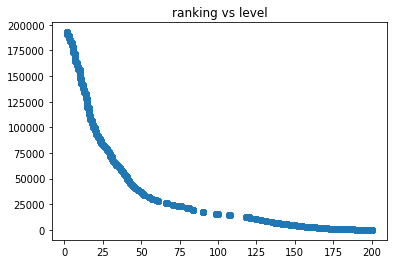

In [60]:
plt.scatter(df["level"], df["rank"])
plt.title("ranking vs level")

In [140]:
df.to_json("../data/sample_ranking_20210509.json", orient="records")

In [74]:
df.groupby("mastery").sum().level.sort_values()

mastery
sniper                         80
outlaw                        100
mage (fire/poison)            118
crossbowman                   157
page                          211
crusader                      297
marauder                      334
gunslinger                    354
pirate                        408
ranger                        434
bowman                        442
hunter                        486
bandit                        500
wizard (fire/poison)          591
mage (ice/lightning)          596
brawler                       661
dragon knight                 687
fighter                       740
chief bandit                  802
wizard (ice/lightning)        847
thief                         868
hermit                        890
corsair                       969
spearman                     1043
beginner                     1235
cleric                       1324
magician                     1329
assassin                     1449
warrior                      1542
priest

# leveling history

In [123]:
def parse_levels_row(tr, name):
    td = tr.find_all("td")
    return dict(
        name=name,
        level=int(td[0].getText()),
        timestamp=td[1].getText().replace(" ", "T")
    )

def parse_levels_page(resp):
    soup = BeautifulSoup(resp.text)
    name = resp.url.split("=")[-1]
    rows = soup.find_all("tr")[1:]
    return [parse_levels_row(tr, name) for tr in rows]

def get_levels(name):
    url = f"https://maplelegends.com/levels?name={name}"
    return requests.get(url)

In [105]:
resp = get_levels("geospiza")

In [124]:
parse_levels_page(resp)[:3]

[{'name': 'geospiza', 'level': 142, 'timestamp': '2021-04-28T02:57:30'},
 {'name': 'geospiza', 'level': 141, 'timestamp': '2021-03-21T03:22:02'},
 {'name': 'geospiza', 'level': 140, 'timestamp': '2021-03-05T02:43:26'}]

In [127]:
res_levels = []
for name in tqdm(df.name):
    resp = get_levels(name)
    res_levels.append(parse_levels_page(resp))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [128]:
levels_df = pd.DataFrame(sum(res_levels, []))

,name,level,timestamp
0,Unlucky,200,2016-08-07T16:27:09
1,Unlucky,199,2016-07-24T12:45:27
2,Unlucky,198,2016-07-14T07:50:14
3,Unlucky,197,2016-06-24T00:51:22
4,Unlucky,196,2016-06-09T07:10:15
...,...,...,...
78378,Lawkes,2,2021-04-15T18:44:22
78379,Troyy,2,2021-04-24T07:52:33
78380,Liridas,2,2021-04-26T21:29:08
78381,Footwear,2,2021-04-28T08:38:13


In [139]:
df.to_json("../data/sample_levels_20210509.json", orient="records")

# sqlite dump

In [147]:
import sqlite3

conn = sqlite3.connect("../data/sample_20210509.sqlite")
df.to_sql("ranking", conn, if_exists="replace")
levels_df.to_sql("levels", conn, if_exists="replace")
conn.close()

Text(0.5, 1.0, 'month vs new players')

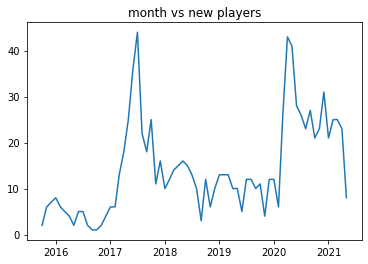

In [168]:
conn = sqlite3.connect("../data/sample_20210509.sqlite")
res = pd.read_sql_query("""
SELECT 
    date(timestamp, "start of month") as month,
    count(distinct name) as n
FROM levels
WHERE level = 2
group by 1
""", conn)
res["month"] = pd.to_datetime(res.month)
plt.plot(res.month, res.n)
plt.title("month vs new players")